<a href="https://colab.research.google.com/github/rhohye22/bigdata_project/blob/main/violence_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm

In [ ]:
# 새롭게 추가된 영상이 있는 폴더
new_video_folder_dir = '....' 

# 새 영상에서 변환한 npy파일이 있는 폴더
new_npy_dir = '...'

# npy 파일이 있는 폴더의 상위폴더
new_npy_ParentFolder= '...'

## load model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.models import load_model
from keras.optimizers import SGD

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model = load_model('/content/drive/MyDrive/4_19data/keras_model.h5',
                  compile=False)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Transform Video to .npy Format

In [ ]:

def getOpticalFlow(video):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel]. dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img,(224,224,1)))

    flows = []
    for i in range(0,len(video)-1):
        # calculate optical flow between each pair of frames
        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i+1], None, 0.5, 3, 15, 3, 5, 1.2, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])
        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0],None,0,255,cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1],None,0,255,cv2.NORM_MINMAX)
        # Add into list 
        flows.append(flow)
        
    # Padding the last frame as empty array
    flows.append(np.zeros((224,224,2)))
      
    return np.array(flows, dtype=np.float32)

## 영상 > npy

In [ ]:
def Video2Npy(file_path, resize=(224,224)):
    """Load video and tansfer it into .npy format
    Args:
        file_path: the path of video file
        resize: the target resolution of output video
    Returns:
        frames: gray-scale video
        flows: magnitude video of optical flows 
    """
    # Load video
    cap = cv2.VideoCapture(file_path)
    # Get number of frames
    len_frames = int(cap.get(7))
    # Extract frames from video
    try:
        frames = []
        for i in range(len_frames-1):
            _, frame = cap.read()
            frame = cv2.resize(frame,resize, interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = np.reshape(frame, (224,224,3))
            frames.append(frame)   
    except:
        print("Error: ", file_path, len_frames,i)
    finally:
        frames = np.array(frames)
        cap.release()
            
    # Get the optical flow of video
    flows = getOpticalFlow(frames)
    
    result = np.zeros((len(flows),224,224,5))
    result[...,:3] = frames
    result[...,3:] = flows
    
    return result

# TO DO

## 폴더 속 최근에 추가된 영상의 npy 저장

In [ ]:
def RecentVideoSave2Npy(file_dir, save_dir):
    """Transfer the video and save them into specified directory
    Args:
        file_dir: 추가된 영상이 있는 폴더
        save_dir: npy로 변환후 저장될 위치
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    
    # 폴더에 최근에 추가된 영상 이름(v) 가져오기
    
    files_dir = "/content/drive/MyDrive/4_19data/example/" # 파일들이 들어있는 폴더
    file_name_and_time_lst = []
    # 해당 경로에 있는 파일들의 생성시간을 함께 리스트로 넣어줌. 
    for f_name in os.listdir(f"{files_dir}"):
        written_time = os.path.getctime(f"{files_dir}{f_name}")
        file_name_and_time_lst.append((f_name, written_time))
    # 생성시간 역순으로 정렬하고, 
    sorted_file_lst = sorted(file_name_and_time_lst, key=lambda x: x[1], reverse=True)
    # 가장 앞에 있는 놈을 넣어준다.
    recent_file = sorted_file_lst[0]
    recent_file_name = recent_file[0]
    v = recent_file_name
    
    video_name = v.split('.')[0]
        # Get src 
    video_path = os.path.join(file_dir, v)
        # Get dest 
    save_path = os.path.join(save_dir, video_name+'.npy') 
        # Load and preprocess video
    data = Video2Npy(file_path=video_path, resize=(224,224))
    data = np.uint8(data)
        # Save as .npy file
    np.save(save_path, data)
    
    return None

In [ ]:
RecentVideoSave2Npy(new_video_folder_dir,new_npy_dir)

NameError: ignored

## Build Data Loader


In [ ]:
from keras.utils import Sequence
from keras.utils import np_utils

class DataGenerator(Sequence):
    """Data Generator inherited from keras.utils.Sequence
    Args: 
        directory: the path of data set, and each sub-folder will be assigned to one class
        batch_size: the number of data points in each batch
        shuffle: whether to shuffle the data per epoch
    Note:
        If you want to load file with other data format, please fix the method of "load_data" as you want
    """
    def __init__(self, directory, batch_size=1, shuffle=True, data_augmentation=True):
        # Initialize the params
        self.batch_size = batch_size
        self.directory = directory
        self.shuffle = shuffle
        self.data_aug = data_augmentation
        # Load all the save_path of files, and create a dictionary that save the pair of "data:label"
        self.X_path, self.Y_dict = self.search_data() 
        # Print basic statistics information
        self.print_stats()
        return None
        
    def search_data(self):
        X_path = []
        Y_dict = {}
        # list all kinds of sub-folders
        self.dirs = sorted(os.listdir(self.directory))
        one_hots = np_utils.to_categorical(range(len(self.dirs)))
        for i,folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory,folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path,file)
                # append the each file path, and keep its label  
                X_path.append(file_path)
                Y_dict[file_path] = one_hots[i]
        return X_path, Y_dict
    
    def print_stats(self):
        # calculate basic information
        self.n_files = len(self.X_path)
        self.n_classes = len(self.dirs)
        self.indexes = np.arange(len(self.X_path))
        np.random.shuffle(self.indexes)
        # Output states
        print("Found {} files belonging to {} classes.".format(self.n_files,self.n_classes))
        for i,label in enumerate(self.dirs):
            print('%10s : '%(label),i)
        return None
    
    def __len__(self):
        # calculate the iterations of each epoch
        steps_per_epoch = np.ceil(len(self.X_path) / float(self.batch_size))
        return int(steps_per_epoch)

    def __getitem__(self, index):
        """Get the data of each batch
        """
        # get the indexs of each batch
        batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # using batch_indexs to get path of current batch
        batch_path = [self.X_path[k] for k in batch_indexs]
        # get batch data
        batch_x, batch_y = self.data_generation(batch_path)
        return batch_x, batch_y

    def on_epoch_end(self):
        # shuffle the data at each end of epoch
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, batch_path):
        # load data into memory, you can change the np.load to any method you want
        batch_x = [self.load_data(x) for x in batch_path]
        batch_y = [self.Y_dict[x] for x in batch_path]
        # transfer the data format and take one-hot coding for labels
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        return batch_x, batch_y
      
    def normalize(self, data):
        mean = np.mean(data)
        std = np.std(data)
        return (data-mean) / std
    
    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(m=video, axis=2)
        return video    
    
    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval 
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and 
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])     
        # calculate numer of padded frames and fix it 
        num_pad = target_frames - len(sampled_video)
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try: 
                    padding.append(video[i])
                except:
                    padding.append(video[0])
            sampled_video += padding     
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)
    
    def random_clip(self, video, target_frames=64):
        start_point = np.random.randint(len(video)-target_frames)
        return video[start_point:start_point+target_frames]
    
    def dynamic_crop(self, video):
        # extract layer of optical flow from video
        opt_flows = video[...,3]
        # sum of optical flow magnitude of individual frame
        magnitude = np.sum(opt_flows, axis=0)
        # filter slight noise by threshold 
        thresh = np.mean(magnitude)
        magnitude[magnitude<thresh] = 0
        # calculate center of gravity of magnitude map and adding 0.001 to avoid empty value
        x_pdf = np.sum(magnitude, axis=1) + 0.001
        y_pdf = np.sum(magnitude, axis=0) + 0.001
        # normalize PDF of x and y so that the sum of probs = 1
        x_pdf /= np.sum(x_pdf)
        y_pdf /= np.sum(y_pdf)
        # randomly choose some candidates for x and y 
        x_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=x_pdf)
        y_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=y_pdf)
        # get the mean of x and y coordinates for better robustness
        x = int(np.mean(x_points))
        y = int(np.mean(y_points))
        # avoid to beyond boundaries of array
        x = max(56,min(x,167))
        y = max(56,min(y,167))
        # get cropped video 
        return video[:,x-56:x+56,y-56:y+56,:]  
    
    def color_jitter(self,video):
        # range of s-component: 0-1
        # range of v component: 0-255
        s_jitter = np.random.uniform(-0.2,0.2)
        v_jitter = np.random.uniform(-30,30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
            s = hsv[...,1] + s_jitter
            v = hsv[...,2] + v_jitter
            s[s<0] = 0
            s[s>1] = 1
            v[v<0] = 0
            v[v>255] = 255
            hsv[...,1] = s
            hsv[...,2] = v
            video[i] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return video
        
    def load_data(self, path):
        # load the processed .npy files which have 5 channels (1-3 for RGB, 4-5 for optical flows)
        data = np.load(path, mmap_mode='r')
        data = np.float32(data)
        # sampling 64 frames uniformly from the entire video
        data = self.uniform_sampling(video=data, target_frames=64)
        # whether to utilize the data augmentation
        if  self.data_aug:
            data[...,:3] = self.color_jitter(data[...,:3])
            data = self.random_flip(data, prob=0.5)
        # normalize rgb images and optical flows, respectively
        data[...,:3] = self.normalize(data[...,:3])
        data[...,3:] = self.normalize(data[...,3:])
        return data


In [ ]:
num_epochs  = 30
num_workers = 16
batch_size  = 8

## TO DO

In [ ]:
import os
import numpy as np

dataset = 'ViolentFlow-opt'
num_epochs  = 30
num_workers = 16
batch_size  = 8

val_generator = DataGenerator(directory=new_npy_ParentFolder.format(dataset),
                              batch_size=batch_size, 
                              data_augmentation=False)

In [ ]:
predict=model.predict(val_generator)


In [ ]:
predict

array([[0.9359904, 0.0640096]], dtype=float32)

In [ ]:
predict.shape

(1, 2)

In [ ]:
Fight = predict[0][0]
Nonfight = predict[0][1]

In [ ]:
print(Fight)
print(Nonfight)

0.9359904
0.0640096


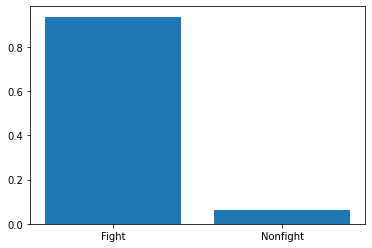

In [ ]:
x = ['Fight', 'Nonfight']
y = [Fight, Nonfight]

plt.bar(x, y)

plt.show()

In [ ]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm

## load model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.models import load_model
from keras.optimizers import SGD

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model = load_model('/content/drive/MyDrive/4_19data/keras_model.h5',
                  compile=False)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
import os
import numpy as np

dataset = 'ViolentFlow-opt'
num_epochs  = 30
num_workers = 16
batch_size  = 8

train_generator = DataGenerator(directory='/content/drive/MyDrive/4_19data/team_video_npy'.format(dataset),
                              batch_size=batch_size, 
                              data_augmentation=False)

Found 53 files belonging to 2 classes.
     Fight :  0
  NonFight :  1


In [ ]:
pred = model.predict(train_generator)

# Test the Model

In [ ]:
result = model.evaluate(train_generator)

7/7 [==============================] - 44s 7s/step - loss: 0.4121 - accuracy: 0.8302


 # Print the Model Accuracy

In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.4121137261390686
accuracy 0.8301886916160583
